In [5]:
import pandas as pd
from matplotlib.pyplot import figure
import itertools
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from random import shuffle
from surprise.model_selection import KFold


In [6]:
def get_data(filename=  'data_pos_neg_neu.txt'):
    '''
    read the list of dict for postive,negative,neutral feedback
    '''
    data = []
    with open(filename) as f:
        for i, line in enumerate(f):
            try:
                d = eval(line)
            except:
                print("*****Error*****")
                print(i,line)
                print("*********END of ERROR *******")
                break
            else:
                data.append(d)
    return data

In [7]:
data = get_data()

In [8]:
result = []
for j in range(len(data)):    
    for i in data[j]['pos']:
        result.append(('user'+str(j),i,1))
    for i in data[j]['neg']:
        result.append(('user'+str(j),i,-1))
    for i in data[j]['neu']:
        result.append(('user'+str(j),i,0))

In [9]:
shuffle(result) # 打乱数据

In [10]:
# 用dict表示
c = []
for line in tqdm(result):
    d = dict(zip(['user','product','rating'],[]))
    d['user'] = line[0]
    d['product'] = line[1]
    d['rating'] = line[2]
    c.append(d)

100%|██████████| 1859626/1859626 [00:03<00:00, 603441.54it/s]


In [11]:
# 抄的老师的workbook4
productsPerUser = defaultdict(set)
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)
ratingDict = {}

In [12]:
# 把一位用户对应的所有产品整理出来
for d in c:
    user,item,rating = d['user'],d['product'],d['rating']
    productsPerUser[user].add((item,rating))
    itemsPerUser[user].add(item)
    usersPerItem[item].add(user)
    ratingDict[(user,item)] = rating

In [13]:
# 计算user average 和 item average
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [14]:
# 查看一共有多少pos，neg，neu
pos = 0
neg = 0
neu = 0
for i in tqdm([i for i in productsPerUser]):
    for j in productsPerUser[i]:
        if j[1] == 1:
            pos += 1
        elif j[1] == -1:
            neg += 1
        else:
            neu += 1

100%|██████████| 83384/83384 [00:00<00:00, 85062.68it/s]


In [15]:
pos,neg,neu

(859773, 572505, 427348)

In [16]:
# similarity functions
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom


In [17]:
# define the similarity function
def mostSimilar(i, N):
    similarities = []
    items = itemsPerUser[i]
    for i2 in itemsPerUser:
        if i2 == i: continue
        sim = Jaccard(items, itemsPerUser[i2])
        #sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

In [18]:
# find top 10 similar users with user10
mostSimilar('user2',10)

[(0.6190476190476191, 'user16778'),
 (0.5909090909090909, 'user5807'),
 (0.5652173913043478, 'user22033'),
 (0.5517241379310345, 'user82333'),
 (0.5454545454545454, 'user19530'),
 (0.5357142857142857, 'user76767'),
 (0.5357142857142857, 'user70477'),
 (0.5217391304347826, 'user29118'),
 (0.52, 'user80000'),
 (0.52, 'user38407')]

In [22]:
sim_save =defaultdict(float)
def avg_rating_similar_user(user,item,sim_threshold , num_users ):
    '''
    return avg rating of most similar num_users users
    if avg similarity of the top 5 less than sim_threshold, return -2 singaling switching
    '''
    worked_user = usersPerItem[item]  # users woked with the items
    # compute similarites bewteen these worked_user and user
    sim_list =[]
    items   = itemsPerUser[user]
    for u in worked_user:
        if u == user : continue
        if (u,user) in sim_save:
            sim  =  sim_save[(u,user)]
        elif (user,u) in sim_save:
            sim  =  sim_save[(user,u)]
        else:
            sim = Jaccard(items, itemsPerUser[u])
            sim_save[(user,u)] = sim
        sim_list.append((sim,u))
    sim_list = sorted(sim_list,reverse =True)
    # compute avg rating from top 5 user
    sim_topk = [ele[0] for ele in sim_list[:num_users]]
    if np.mean(sim_topk) <sim_threshold:
        return -2
    rating_topk=  [ ratingDict[(ele[1],item)]   for ele in sim_list[:num_users]]
    return np.mean(rating_topk)

In [23]:
avg_rating_similar_user('user18927','ASP.NET',sim_threshold = 0.1,num_users =10)

0.0

In [24]:
def siwthching_hybrid(test_data,model,sim_threshold = 0.1,num_users =10):
    '''
    making prediction using avg_rating_similar_user 
    switching to other model when prediction not avaliable(value =-2)
    '''
    #Prediction(uid='user11141', iid='.NET Framework', r_ui=1.0, est=0.24529294708725582, details={'was_impossible': False})
    predictions =[]
    for sample in tqdm(test_data):
        u,i,r = sample
        rating = avg_rating_similar_user(u,i,sim_threshold,num_users)
        if rating == -2:
            rating =  algo.predict(u, i, r_ui=r)
        predictions.append((u,i,r,rating,None))
    return predictions
        

In [21]:
#kernel dead last night
#prediction = siwthching_hybrid(testset,algo_svd)

In [15]:
# 所有的rating mean
ratingMean = sum([d[2] for d in result])/len(result)

In [16]:

ratingMean

0.15447622263831545

In [17]:
# 老师的代码
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

In [18]:
# 老师的代码
for d in c:
    user,item = d['user'], d['product']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

In [19]:
# 老师的代码
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['product']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [20]:
# 预测用户1对python 的评分
predictRating('user1','Python')

-0.6175758828930583

In [21]:
# 找出所有的产品
all_products = np.array([i[1] for i in result])

In [22]:
# 找出所有产品的unique，去掉重复的
all_products = np.unique(all_products)

In [23]:
# 预测用户1对所有产品的评分
prediction = []
for i in all_products:
    a = predictRating('user1',i)
    prediction.append([i,a])

In [24]:
# 排列一下
prediction.sort(key=lambda x: x[1],reverse=True)

In [25]:
# 写成一个function
def predict_all(user):
    #user = str(user)
    prediction = []
    for i in all_products:
        a = predictRating(user,i)
        prediction.append([i,a])
        prediction.sort(key=lambda x: x[1],reverse=True)
    return prediction

In [26]:
all_users = np.unique(np.array([i[0] for i in result]))

## SVM with surprise

In [37]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import accuracy

In [55]:
# split the data into 0.9 and 0.1
train_size = int(len(result)*0.8)
#test = int(len(productsPerUser)*0.84)

In [56]:
train = result[:train_size]
test = result[train_size:]

In [57]:
len(train),len(test)

(1487700, 371926)

# prepare train test data


In [58]:
# trai  dataframe
train_df = pd.DataFrame(train,columns = ['userID', 'itemID', 'rating'])

In [59]:
# scale, from -1 to 1
reader = Reader(rating_scale=(-1,1))

In [60]:
# transform the data so that surprise package can handle the data
train_data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
trainset = train_data.build_full_trainset()

In [61]:
testset = test

In [62]:
# define the svd function 
algo_svd = SVD()

# Train the algorithm on the trainset
algo_svd.fit(trainset)


In [63]:
#predict ratings for the testset
predictions_svd = algo_svd.test(testset)
# Then compute RMSE
accuracy.rmse(predictions_svd)

RMSE: 0.6553


0.6553072456125196

In [65]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [66]:
#predictions_svd = algo_svd.test(valid_data)

In [67]:
precisions, recalls = precision_recall_at_k(predictions_svd, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.7358099440495638
average recall@5 is:  0.7066905416075467
average f1 score @5 is  0.6340697328801094


## BaselineOnly

In [68]:
from surprise import BaselineOnly # algorithm that is used to establish minimum expected performance on a dataset

In [69]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

In [70]:
algo_base = BaselineOnly(bsl_options=bsl_options)

In [71]:
algo_base.fit(trainset)
predictions_base = algo_base.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_base)

Estimating biases using als...
RMSE: 0.7404


0.7403718735472166

In [72]:
predictions_base = algo_base.test(testset)

In [73]:
precisions, recalls = precision_recall_at_k(predictions_base, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.6911162506946592
average recall@5 is:  0.6738318504076442
average f1 score @5 is  0.5835315019884054


### using sgd

In [74]:
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
algo_base2 = BaselineOnly(bsl_options=bsl_options)

In [75]:
algo_base2.fit(trainset)
predictions_base2 = algo_base2.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_base2)

Estimating biases using sgd...
RMSE: 0.8297


0.8296570235322551

In [76]:
predictions_base2 = algo_base2.test(testset)
precisions, recalls = precision_recall_at_k(predictions_base2, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.7185768785595601
average recall@5 is:  0.7302497402716565
average f1 score @5 is  0.6051204400408519


## SlopeOne

In [77]:
from surprise import SlopeOne

In [78]:
algo_slope = SlopeOne()

In [79]:
algo_slope.fit(trainset)
predictions_slope = algo_slope.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_slope)

/tmp/ipykernel_2744/1804627863.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo_slope.fit(trainset)


RMSE: 0.7286


0.7285658084103336

In [80]:
predictions_slope = algo_slope.test(testset)
precisions, recalls = precision_recall_at_k(predictions_slope, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.6840236253702994
average recall@5 is:  0.6847878743423346
average f1 score @5 is  0.5914606965011795


## Coslustering

In [81]:
from surprise import CoClustering

In [82]:
algo_co = CoClustering()

In [83]:
algo_co.fit(trainset)
predictions_co = algo_co.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_co)

/tmp/ipykernel_2744/2540439433.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo_co.fit(trainset)


RMSE: 0.7185


0.7185057938716517

In [84]:
predictions_co = algo_co.test(valid_data)
precisions, recalls = precision_recall_at_k(predictions_co, k=5, threshold=0)

print('average precision@5 is: ', sum(prec for prec in precisions.values()) / len(precisions))
print('average recall@5 is: ',sum(rec for rec in recalls.values()) / len(recalls))
print('average f1 score @5 is ', sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions))

average precision@5 is:  0.7175461214047314
average recall@5 is:  0.4324659026192562
average f1 score @5 is  0.3373966560258921


## weighted

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
def precision_recall_at_k_weighted(pred1,pred2,weight1, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    pred = [(i.uid,i.r_ui,weight1*i.est+(1-weight1)*j.est) for i,j in zip(pred1,pred2)]
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for i in pred:
        uid,true_r,est = i[0],i[1],i[2]
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
    a = sum(prec for prec in precisions.values()) / len(precisions)
    b = sum(rec for rec in recalls.values()) / len(recalls)
    c = sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions)
    print('average precision@5 is: ', a)
    print('average recall@5 is: ',b)
    print('average f1 score @5 is ', c)
    return a, b, c

In [87]:
# combine baseline model and coclustering model, with baseline 0.8 and coclustering weighted 0.2
precision_recall_at_k_weighted(predictions_base,predictions_co,0.8, k=10, threshold=0)

average precision@5 is:  0.6788099658986835
average recall@5 is:  0.7335329685721654
average f1 score @5 is  0.6404355195846528


(0.6788099658986835, 0.7335329685721654, 0.6404355195846528)

In [88]:
# select model from:
#predictions_base,predictions_base2,predictions_slope,predictions_co,predictions_svd
def two_weighted_model(model1,model2):
    weight = []
    for i in [i/10 for i in range(1,10)]:
        print('when weight is: ',i)
        d,e,f = precision_recall_at_k_weighted(model1,model2,i, k=10, threshold=0)
        weight.append([i,d,e,f])
    newdata = []
    for i in weight:
        newdata.append([i[0],i[1],'precision'])
    for i in weight:
        newdata.append([i[0],i[2],'recall'])
    for i in weight:
        newdata.append([i[0],i[3],'f1'])        
    df = pd.DataFrame(newdata,columns=['weight','value','type'])
    sns.lineplot(data=df,x='weight',y='value',hue='type')
    plt.show()
        

when weight is:  0.1
average precision@5 is:  0.7310085970130635
average recall@5 is:  0.753248125093246
average f1 score @5 is  0.6688591748326375
when weight is:  0.2
average precision@5 is:  0.73241221768354
average recall@5 is:  0.7573218161916818
average f1 score @5 is  0.670650348577993
when weight is:  0.3
average precision@5 is:  0.7331452550182463
average recall@5 is:  0.7607887670654281
average f1 score @5 is  0.671321906477182
when weight is:  0.4
average precision@5 is:  0.7334639370563071
average recall@5 is:  0.7648071047187989
average f1 score @5 is  0.6716550601835872
when weight is:  0.5
average precision@5 is:  0.7340357480620989
average recall@5 is:  0.7691668120037218
average f1 score @5 is  0.6713169153780485
when weight is:  0.6
average precision@5 is:  0.7332818230856905
average recall@5 is:  0.7735254074037571
average f1 score @5 is  0.6692295611446172
when weight is:  0.7
average precision@5 is:  0.7327531752299382
average recall@5 is:  0.7833158324409919
avera

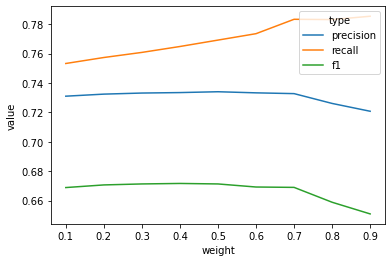

In [89]:
# example
two_weighted_model(predictions_base2,predictions_svd)

In [96]:
from collections import Counter
# number of user interaction data
#Counter(sorted(Counter(train_df['userID']).values()))

In [98]:
user_count =Counter(train_df['userID'])

In [103]:
def switch(test_data,baseline_pred,model_pred,user_count= user_count,num_interaction =3):
    predictions =[]
    for true_sample,b_pre,m_pre in zip(test_data,baseline_pred,model_pred):
        u,i,r = true_sample
        if user_count[u] <=num_interaction:
            pred = m_pre
        else:
            pred =b_pre
        predictions.append(pred)
    return predictions

In [123]:
def precision_recall_f1_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
    a = sum(prec for prec in precisions.values()) / len(precisions)
    b = sum(rec for rec in recalls.values()) / len(recalls)
    c = sum(prec*recall for prec, recall in zip(precisions.values(),recalls.values()))/len(precisions)
    print('average precision@5 is: ', a)
    print('average recall@5 is: ',b)
    print('average f1 score @5 is ', c)

    return a,b,c

1
average precision@5 is:  0.715382521913852
average recall@5 is:  0.7813720133200658
average f1 score @5 is  0.6403818505108452
2
average precision@5 is:  0.7153177548038441
average recall@5 is:  0.781331272718609
average f1 score @5 is  0.6403261368678277
3
average precision@5 is:  0.7153902870028476
average recall@5 is:  0.7814273787528144
average f1 score @5 is  0.640469830187901
4
average precision@5 is:  0.715400524384752
average recall@5 is:  0.7814601801601414
average f1 score @5 is  0.6405804217692913
5
average precision@5 is:  0.7155634071996597
average recall@5 is:  0.7817956857286206
average f1 score @5 is  0.64098401523673
10
average precision@5 is:  0.7171244388093924
average recall@5 is:  0.7839108840323806
average f1 score @5 is  0.6458082990593287
20
average precision@5 is:  0.7229167276034525
average recall@5 is:  0.7739621923737156
average f1 score @5 is  0.6595220661281247
30
average precision@5 is:  0.7274628315384504
average recall@5 is:  0.7589133119032664
averag

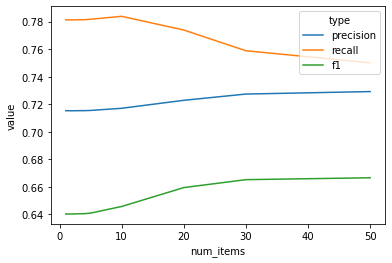

In [128]:
newdata = []
for count in [1,2,3,4,5,10,20,30,50]:
    print(count)
    prediction_switch = switch(testset,predictions_base2,predictions_svd,num_interaction =count)
    precision,recall,f1 = precision_recall_f1_at_k(prediction_switch,k =10,threshold =0)
    newdata.append([count,precision,'precision'])
    newdata.append([count,recall,'recall'])
    newdata.append([count,f1,'f1'])        
df = pd.DataFrame(newdata,columns=['num_items','value','type'])
sns.lineplot(data=df,x='num_items',y='value',hue='type')
plt.show()

In [121]:
prediction_switch[0]

Prediction(uid='user2541', iid='Java', r_ui=1, est=-0.05350177263332043, details={'was_impossible': False})